In [1]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hashlib import sha256
sns.set()

## Data Loading and Cleaning

In [2]:
# Load applications data
train = pd.read_csv('../input/application_train.csv')
test = pd.read_csv('../input/application_test.csv')

In [ ]:
train.head()

In [ ]:
# Print info about each column in the train dataset
for col in train:
    print(col)
    Nnan = train[col].isnull().sum()
    print('Number empty: ', Nnan)
    print('Percent empty: ', 100*Nnan/train.shape[0])
    print(train[col].describe())
    if train[col].dtype==object:
        print('Categories and Count:')
        print(train[col].value_counts().to_string(header=None))
    print()

In [ ]:
# Print info about each column in the test dataset
for col in test:
    print(col)
    Nnan = test[col].isnull().sum()
    print('Number empty: ', Nnan)
    print('Percent empty: ', 100*Nnan/test.shape[0])
    print(test[col].describe())
    if test[col].dtype==object:
        print('Categories and Count:')
        print(test[col].value_counts().to_string(header=None))
    print()

The column containing the values we are trying to predict, `TARGET`, doesn't contain any missing values.  The value of `TARGET` is $0$ when the loan was repayed sucessfully, and $1$ when there were problems repaying the loan.  Many more loans were succesfully repayed than not, which means that the dataset is imbalanced in terms of our dependent variable, which is something we'll have to watch out for when we build a predictive model later:

In [ ]:
# Show target distribution
train['TARGET'].value_counts()

There's a lot of categorical columns - let's check that, for each column, all the categories we see in the training set we also see in the test set, and vice-versa.

In [ ]:
for col in test:
    if test[col].dtype==object:
        print(col)
        print('Num Unique in Train:', train[col].nunique())
        print('Num Unique in Test: ', test[col].nunique())
        print('Unique in Train:', sorted([str(e) for e in train[col].unique().tolist()]))
        print('Unique in Test: ', sorted([str(e) for e in test[col].unique().tolist()]))
        print()

The gender column contains whether the loan applicant was male or female.  The training datset contains 4 values which weren't empty but were labelled `XNA`.  Normally we would want to create a new column to represent when the gender value is null.  However,  since the test dataset has only `M` and `F` entries, and because there are only 4 entries with a gender of `XNA` in the training set, we'll remove those entries from the training set.

In [3]:
# Remove entries with gender = XNA
train = train[train['CODE_GENDER'] != 'XNA']

The `NAME_INCOME_TYPE` column also contained entries for applicants who were on Maternity leave, but no such applicants were in the test set.  There were only 5 such applicants in the training set, so we'll remove these from the training set.

In [4]:
# Remove entries with income type = maternity leave
train = train[train['NAME_INCOME_TYPE'] != 'Maternity leave']

Similarly, in the `NAME_FAMILY_STATUS` column, there were 2 entries in the training set with values of `Unknown`, and no entries with that value in the test set.  So, we'll remove those too.

In [5]:
# Remove entries with unknown family status
train = train[train['NAME_FAMILY_STATUS'] != 'Unknown']

There were some funky values in the `DAYS_EMPLOYED` column:

In [ ]:
train['DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.show()

$350,000$ days?  That's like $1,000$ years!  Looks like all the reasonable values represent the number of days between when the applicant was employed and the date of the loan application.  The unreasonable values are all exactly $365,243$, so we'll set those to `NaN`.

In [ ]:
# Show distribution of reasonable values
train.loc[train['DAYS_EMPLOYED']<200000, 'DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED (which are less than 200,000)')
plt.ylabel('Count')
plt.show()

In [ ]:
# Show all unique outlier values
train.loc[train['DAYS_EMPLOYED']>200000, 'DAYS_EMPLOYED'].unique()

In [6]:
# Set unreasonable values to nan
train.loc[train['DAYS_EMPLOYED']==365243, 'DAYS_EMPLOYED'] = np.nan
test.loc[test['DAYS_EMPLOYED']==365243, 'DAYS_EMPLOYED'] = np.nan

The column `WEEKDAY_APPR_PROCESS_START` contains categorical information corresponding to the day of the week.  We could encode these categories as the values 1-7, but this would imply that Sunday and Monday are more similar than, say Tuesday and Sunday.  We could also one-hot encode the column into 7 new columns, but that would create 7 additional dimensions.  Seeing as the week is cyclical, we'll encode this information into two dimensions by encoding them using polar coordinates.  That is, we'll represent the days of the week as a circle.  That way, we can encode the days of the week independently, but only add two dimensions.

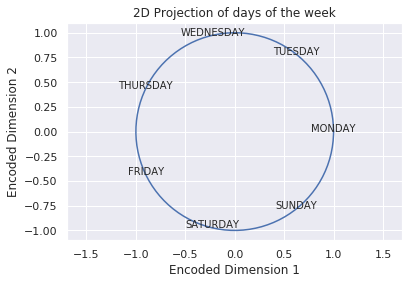

In [7]:
# Create map from categories to polar projection
DOW_map = {
    'MONDAY':    0,
    'TUESDAY':   1,
    'WEDNESDAY': 2,
    'THURSDAY':  3,
    'FRIDAY':    4,
    'SATURDAY':  5,
    'SUNDAY':    6,
}
DOW_map1 = {k: np.cos(2*np.pi*v/7.0) for k, v in DOW_map.items()}
DOW_map2 = {k: np.sin(2*np.pi*v/7.0) for k, v in DOW_map.items()}

# Show encoding of days of week -> circle
days = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']
tt = np.linspace(0, 2*np.pi, 200)
xx = np.cos(tt)
yy = np.sin(tt)
plt.plot(xx,yy)
plt.gca().axis('equal')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.title('2D Projection of days of the week')
for day in days:
    plt.text(DOW_map1[day], DOW_map2[day], day, ha='center')
plt.show()

In [8]:
# WEEKDAY_APPR_PROCESS_START to polar coords
col = 'WEEKDAY_APPR_PROCESS_START'
train[col+'_1'] = train[col].map(DOW_map1)
train[col+'_2'] = train[col].map(DOW_map2)
train.drop(columns=col, inplace=True)
test[col+'_1'] = test[col].map(DOW_map1)
test[col+'_2'] = test[col].map(DOW_map2)
test.drop(columns=col, inplace=True)

For the housing-related features (e.g. `LIVINGAPARTMENTS_MODE`, `BASEMENTAREA_AVG`, etc) there are combinations of some PREFIX (e.g. `LIVINGAPARTMENTS`,  `BASEMENTAREA`, etc) and some POSTFIX (e.g. `MODE`, `MEDI`, `AVG`, etc) into a variable `PREFIX_POSTFIX`.  However, if one value for a given PREFIX is empty, the other values for that PREFIX will also be empty.  

For each column which has some empty values, we want to add an indicator column which is 1 if the value in the corresponding column is empty, and 0 otherwise.  However, if we do this with the housing-related features, we'll end up with a bunch of duplicate columns!  This is because the same samples have null values across all the POSTFIX columns for a given PREFIX.   The same problem crops up with the CREDIT_BUREAU-related features. To handle this problem, after creating the null indicator columns, we'll check for duplicate columns and merge them.

So, first we'll add columns to indicate where there are empty values in each other column.

In [9]:
# Add indicator columns for empty values
for col in test:
    train_null = train[col].isnull()
    test_null = test[col].isnull()
    if (train_null | test_null).sum()>0:
        train[col+'_ISNULL'] = train_null
        test[col+'_ISNULL'] = test_null

Then we can label encode categorical features with only 2 possible values (that is, turn the labels into either 0 or 1).

In [10]:
# Label encoder
le = LabelEncoder()

# Label encode binary fearures in training set
for col in train: 
    if train[col].dtype==object and train[col].nunique()==2:
        if col+'_ISNULL' in train.columns: #missing values here?
            train.loc[train[col+'_ISNULL'], col] = 'NaN'
        train[col] = le.fit_transform(train[col])
        if col+'_ISNULL' in train.columns: #re-remove missing vals
            train.loc[train[col+'_ISNULL'], col] = np.nan
            
# Label encode binary fearures in test set
for col in test: 
    if test[col].dtype==object and test[col].nunique()==2:
        if col+'_ISNULL' in test.columns: #missing values here?
            test.loc[test[col+'_ISNULL'], col] = 'NaN'
        test[col] = le.fit_transform(test[col])
        if col+'_ISNULL' in test.columns: #re-remove missing vals
            test.loc[test[col+'_ISNULL'], col] = np.nan

Then we'll one-hot encode the categorical features which have more than 2 possible values.

In [11]:
# Get categorical features to encode
cat_features = []
for col in train: 
    if train[col].dtype==object and train[col].nunique()>2:
        cat_features.append(col)

# One-hot encode categorical features in train set
train = pd.get_dummies(train, columns=cat_features)

# One-hot encode categorical features in test set
test = pd.get_dummies(test, columns=cat_features)

And finally we'll remove duplicate columns.  We'll hash the columns and check if the hashes match before checking if all the values actually match, because it's a lot faster than comparing $O(N^2)$ columns elementwise.

In [12]:
# Hash columns
hashes = dict()
for col in train:
    hashes[col] = sha256(train[col].values).hexdigest()
    
# Get list of duplicate column lists
Ncol = train.shape[1] #number of columns
dup_list = []
dup_labels = -np.ones(Ncol)
for i1 in range(Ncol):
    if dup_labels[i1]<0: #if not already merged,
        col1 = train.columns[i1]
        t_dup = [] #list of duplicates matching col1
        for i2 in range(i1+1, Ncol):
            col2 = train.columns[i2]
            if ( dup_labels[i2]<0 #not already merged
                 and hashes[col1]==hashes[col2] #hashes match
                 and train[col1].equals(train[col2])): #cols are equal
                #then this is actually a duplicate
                t_dup.append(col2)
                dup_labels[i2] = i1
        if len(t_dup)>0: #duplicates of col1 were found!
            t_dup.append(col1)
            dup_list.append(t_dup)
        
# Merge duplicate columns
for iM in range(len(dup_list)):
    new_name = 'Merged'+str(iM)
    train[new_name] = train[dup_list[iM][0]].copy()
    test[new_name] = test[dup_list[iM][0]].copy()
    train.drop(columns=dup_list[iM], inplace=True)
    test.drop(columns=dup_list[iM], inplace=True)
    print('Merged', dup_list[iM], 'into', new_name)

Merged ['APARTMENTS_MODE_ISNULL', 'APARTMENTS_MEDI_ISNULL', 'APARTMENTS_AVG_ISNULL'] into Merged0
Merged ['BASEMENTAREA_MODE_ISNULL', 'BASEMENTAREA_MEDI_ISNULL', 'BASEMENTAREA_AVG_ISNULL'] into Merged1
Merged ['YEARS_BEGINEXPLUATATION_MODE_ISNULL', 'YEARS_BEGINEXPLUATATION_MEDI_ISNULL', 'YEARS_BEGINEXPLUATATION_AVG_ISNULL'] into Merged2
Merged ['YEARS_BUILD_MODE_ISNULL', 'YEARS_BUILD_MEDI_ISNULL', 'YEARS_BUILD_AVG_ISNULL'] into Merged3
Merged ['COMMONAREA_MODE_ISNULL', 'COMMONAREA_MEDI_ISNULL', 'COMMONAREA_AVG_ISNULL'] into Merged4
Merged ['ELEVATORS_MODE_ISNULL', 'ELEVATORS_MEDI_ISNULL', 'ELEVATORS_AVG_ISNULL'] into Merged5
Merged ['ENTRANCES_MODE_ISNULL', 'ENTRANCES_MEDI_ISNULL', 'ENTRANCES_AVG_ISNULL'] into Merged6
Merged ['FLOORSMAX_MODE_ISNULL', 'FLOORSMAX_MEDI_ISNULL', 'FLOORSMAX_AVG_ISNULL'] into Merged7
Merged ['FLOORSMIN_MODE_ISNULL', 'FLOORSMIN_MEDI_ISNULL', 'FLOORSMIN_AVG_ISNULL'] into Merged8
Merged ['LANDAREA_MODE_ISNULL', 'LANDAREA_MEDI_ISNULL', 'LANDAREA_AVG_ISNULL'] int

In [13]:
# Copy data before aligning
train_copy = train.copy()
test_copy = test.copy()

# Make SK_ID_CURR the index
train.set_index('SK_ID_CURR', inplace=True)
test.set_index('SK_ID_CURR', inplace=True)

# Ensure all data is stored as floats
train = train.astype(np.float32)
test = test.astype(np.float32)

# Target labels
train_y = train['TARGET']

# Align test and training data
train, test = train.align(test, join='inner', axis=1)

In [14]:
# Classification pipeline
xgb_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', XGBClassifier())
])

In [ ]:
# Cross-validated AUROC
auroc_scorer = make_scorer(roc_auc_score, needs_proba=True)
scores = cross_val_score(xgb_pipeline, train, train_y, 
                         cv=3, scoring=auroc_scorer)
print('Mean AUROC:', scores.mean())

# Fit to training data
xgb_fit = xgb_pipeline.fit(train, train_y)

# Predict default probabilities of test data
test_pred = xgb_fit.predict_proba(test)

# Save predictions to file
df_out = pd.DataFrame()
df_out['SK_ID_CURR'] = test.index
df_out['TARGET'] = test_pred[:,1]
df_out.to_csv('xgboost_baseline.csv', index=False)

## Calibration

One problem with the tree-based model is that the predicted probabilities tend to be overconfident.  That is, when the actual probability of class=1 is closer to 0.5, the model predicts probabilities closer to 0 or 1 than 0.5:

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import calibration_curve

In [ ]:
# Predict probabilities for training data
train_pred = cross_val_predict(xgb_pipeline, 
                               train, 
                               y=train_y,
                               method='predict_proba')
train_pred = train_pred[:,1] #only want p(default)

# Show calibration curve
fraction_of_positives, mean_predicted_value = \
    calibration_curve(train_y, train_pred, n_bins=10)
plt.figure()
plt.plot([0 1], [0 1], 'k:', 
         label='Perfectly Calibrated')
plt.plot(mean_predicted_value, 
         fraction_of_positives, 's-',
         label='XGBoost Predictions')
plt.legend()
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration curve for baseline XGBoost model')
plt.show()

We can "calibrate" our model by adjusting predicted probabilities to more accurately reflect the probability of loan default by calibrating the model's predictions using a method based on isotonic regression.

In [ ]:
# Classification pipeline w/ calibration
calib_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', CalibratedClassifierCV(
                        base_estimator=XGBClassifier(),
                        method='isotonic'))
])

In [ ]:
# Predict probabilities for training data
calib_pred = cross_val_predict(calib_pipeline, 
                               train, 
                               y=train_y,
                               method='predict_proba')
calib_pred = calib_pred[:,1] #only want p(default)

# Show calibration curve
fop_calib, mpv_calib = \
    calibration_curve(train_y, calib_pred, n_bins=10)
plt.figure()
plt.plot([0 1], [0 1], 'k:', 
         label='Perfectly Calibrated')
plt.plot(mean_predicted_value, 
         fraction_of_positives, 's-',
         label='XGBoost Predictions')
plt.plot(mpv_calib, fop_calib, 's-',
         label='Calibrated Predictions')
plt.legend()
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration curve for Calibrated XGBoost model')
plt.show()

Now we can output our predictions after calibrating.

In [ ]:
# Cross-validated AUROC
auroc_scorer = make_scorer(roc_auc_score, needs_proba=True)
scores = cross_val_score(calib_pipeline, train, train_y, 
                         cv=3, scoring=auroc_scorer)
print('Mean AUROC with calibration:', scores.mean())

# Fit to training data
calib_fit = calib_pipeline.fit(train, train_y)

# Predict default probabilities of test data
test_pred = calib_fit.predict_proba(test)

# Save predictions to file
df_out = pd.DataFrame()
df_out['SK_ID_CURR'] = test.index
df_out['TARGET'] = test_pred[:,1]
df_out.to_csv('xgboost_calibrated.csv', index=False)

Notes:

Feature selection with Mutual information?  Featuretools?

interaction terms and keep ones w/ high MI?  Poly features shouldn't be needed for tree method... but would want em if doing logistic reg.

Gonna have to do oversampling/undersampling to account for that class imbalance

XGboost

CALIBRATION!

Bayesian paramater optimization?